In [1]:
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.base import clone
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from scipy.special import logit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import shutil
import optuna
import json
import os
import gc

warnings.filterwarnings('ignore')

In [209]:
train_path = '/kaggle/input/playground-series-s4e11/train.csv'
test_path = '/kaggle/input/playground-series-s4e11/test.csv'
sample_sub_path = '/kaggle/input/playground-series-s4e11/sample_submission.csv'

original_data_path = '/kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv'

target = 'Depression'
n_folds = 5
seed = 0

In [30]:
_train = pd.read_csv(train_path, index_col = 'id')
_test = pd.read_csv(test_path, index_col = 'id')
_original = pd.read_csv(original_data_path)

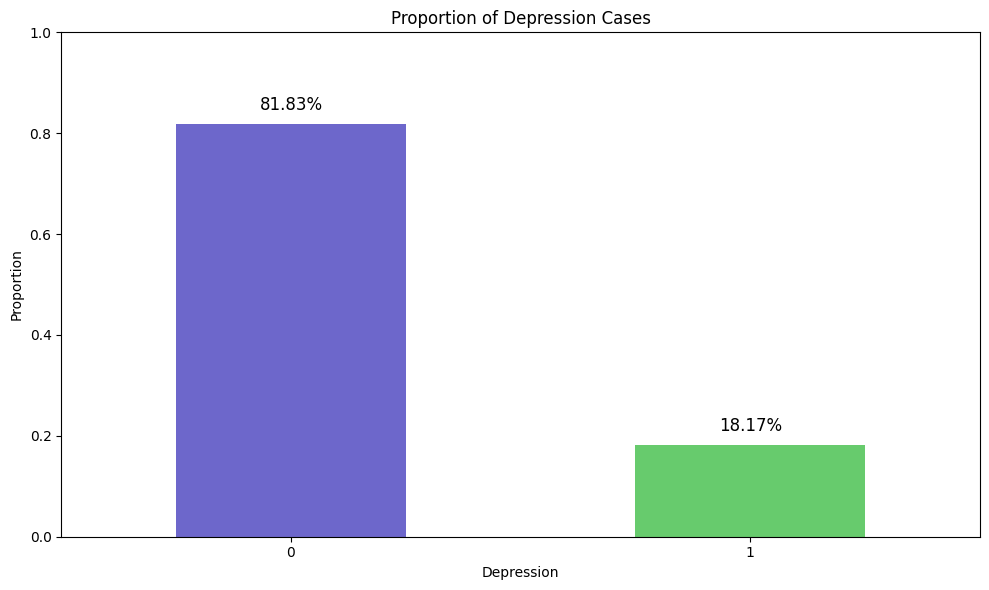

In [4]:
depression_counts = _train.Depression.value_counts(normalize = True).reset_index()
depression_counts.columns = ['Depression', 'Proportion']
palette = {
    0 : sns.color_palette('hls')[4],
    1 : sns.color_palette('hls')[2]
}

plt.figure(figsize = (10, 6))
sns.barplot(
    x = 'Depression',
    y = 'Proportion',
    data = depression_counts,
    palette = palette,
    width = 0.5
)

plt.title('Proportion of Depression Cases')
plt.xlabel('Depression')
plt.ylabel('Proportion')
plt.ylim(0,1)

for index, row in depression_counts.iterrows():
    plt.text(
        row.name,
        row.Proportion + 0.02,
        f'{row.Proportion:.2%}',
        ha = 'center',
        va = 'bottom',
        fontsize = 12
    )
    
plt.tight_layout()
plt.show()

In [63]:
def get_data(model):
    train = pd.read_csv(train_path, index_col='id')
    test = pd.read_csv(test_path, index_col='id')
    original = pd.read_csv(original_data_path)
    original[target] = original[target].map({'Yes':1, 'No':0})
    
    if model == 'cb':
        cat_cols = test.columns.tolist()
    else:
        cat_cols = test.select_dtypes(include = 'object').columns.tolist()
        
    train[cat_cols] = train[cat_cols].astype(str).astype('category')
    test[cat_cols] = test[cat_cols].astype(str).astype('category')
    original[cat_cols] = original[cat_cols].astype(str).astype('category')
    
    for col in cat_cols:
        common_categories = train[col].cat.categories.union(original[col].cat.categories)
        train[col] = train[col].cat.set_categories(common_categories)
        original[col] = original[col].cat.set_categories(common_categories)
        
    for col in train.columns:
        original[col] = original[col].astype(train[col].dtype)
        
    X = train.drop(target, axis = 1)
    y = train[target]
    X_test = test
    
    X_original = original.drop(target, axis = 1)
    y_original = original[target]
    
    return X, y, X_test, X_original, y_original

In [122]:
class Trainer:
    def __init__(self, model, folds=5, seed=0, is_ensemble_model = False):
        self.model = model
        self.n_folds = folds
        self.seed = seed
        self.is_ensemble_model = is_ensemble_model
        
    def fit_predict(self, X, y, X_test, X_original = None, y_original = None, threshold = 0.5):
        print(f'Training {self.model.__class__.__name__}\n')
        
        scores = []
        coeffs = np.zeros((1, X.shape[1]))
        oof_pred_probs = np.zeros(X.shape[0])
        test_pred_probs = np.zeros(X_test.shape[0])
        
        skf = StratifiedKFold(n_splits = self.n_folds, random_state = self.seed, shuffle = True)
        
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            if not self.is_ensemble_model:
                X_train = pd.concat([X_train, X_original], ignore_index = True)
                y_train = pd.concat([y_train, y_original], ignore_index = True)
                
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            if self.is_ensemble_model:
                coeffs += model.coef_ / self.n_folds
                if isinstance(self.model, LogisticRegression):
                    n_iters = model.n_iter_[0]
                    
            y_pred_probs = model.predict(X_val) if isinstance(self.model, Ridge) else model.predict_proba(X_val)[:,1]
            oof_pred_probs[val_idx] = y_pred_probs
            
            temp_test_pred_probs = model.predict(X_test) if isinstance(self.model, Ridge) else model.predict_proba(X_test)[:,1]
            test_pred_probs += temp_test_pred_probs / self.n_folds
            
            score = accuracy_score(y_val, (y_pred_probs > threshold).astype(int))
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            if self.is_ensemble_model and isinstance(self.model, LogisticRegression):
                print(f'--- Fold {fold_idx + 1} - Accuracy: {score:.6f} ({n_iters} iterations)')
            else:
                print(f'--- Fold {fold_idx + 1} - Accuracy: {score:.6f}')
        
        overall_score = accuracy_score(y, (oof_pred_probs > threshold).astype(int))
        print(f'\n------- Overall: {overall_score:.6f} | Average: {np.mean(scores):.6f} +- {np.std(scores):.6f}')
        
        if self.is_ensemble_model:
            return oof_pred_probs, test_pred_probs, scores, coeffs
        else:
            os.makedirs('oof_pred_probs', exist_ok=True)
            os.makedirs('test_pred_probs', exist_ok=True)
            
            self._save_pred_probs(oof_pred_probs, np.mean(scores), 'oof')
            self._save_pred_probs(test_pred_probs, np.mean(scores), 'test')
            
            return oof_pred_probs, test_pred_probs, scores
        
    def fit(self, X, y, threshold=0.5):
        scores = []
        skf = StratifiedKFold(n_splits = self.n_folds, random_state=self.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict(X_val) if isinstance(self.model, Ridge) else model.predict_proba(X_val)
            score = accuracy_score(y_val, (y_pred_probs > threshold).astype(int))
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
        return np.mean(scores)
    
    def _save_pred_probs(self, pred_probs, cv_score, name):
        model_name = self.model.__class__.__name__.lower().replace('classifier', '')
        with open(f'{name}_pred_probs/{model_name}_{name}_pred_probs_{cv_score:.6f}.pkl', 'wb') as f:
            pickle.dump(pred_probs, f)

In [123]:
def save_submission(name, test_pred_probs, score, threshold=0.5):
    sub = pd.read_csv(sample_sub_path)
    sub[target] = (test_pred_probs > threshold).astype(int)
    sub.to_csv(f'sub_{name}_{score:.6f}.csv', index = False)
    return sub.head()

In [96]:
lr_params = {
    "C": 5.559884346567435,
    "max_iter": 1000,
    "n_jobs": 4,
    "penalty": "l2",
    "random_state": 42,
    "solver": "newton-cg",
    "tol": 0.08313081991676836
}

cb_params = {
    "border_count": 180,
    "colsample_bylevel": 0.7351678905666684,
    "depth": 4,
    "iterations": 2372,
    "l2_leaf_reg": 4.442847441200204,
    "learning_rate": 0.0514109059943355,
    "min_child_samples": 146,
    "random_state": 42,
    "random_strength": 0.18678416655567043,
    "scale_pos_weight": 1.019889465491297,
    "subsample": 0.3511896501762123,
    "verbose": False
}

xgb_params = {
    "colsample_bylevel": 0.25155109886677396,
    "colsample_bynode": 0.5723191165109757,
    "colsample_bytree": 0.18034301813835885,
    "enable_categorical": True,
    "gamma": 3.6392698070258622,
    "max_bins": 26161,
    "max_depth": 16,
    "max_leaves": 67,
    "min_child_weight": 34,
    "n_estimators": 3853,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 7.996080341061729,
    "reg_lambda": 46.83054555763492,
    "scale_pos_weight": 1.2157646356820928,
    "subsample": 0.9117754083869292,
    "verbosity": 0
}

lgbm_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.18283018243382332,
    "learning_rate": 0.09945326391012832,
    "max_bins": 36644,
    "min_child_samples": 105,
    "min_child_weight": 0.2083765599710974,
    "n_estimators": 244,
    "n_jobs": -1,
    "num_leaves": 122,
    "random_state": 42,
    "reg_alpha": 8.662578235164972,
    "reg_lambda": 3.5696291074963926,
    "scale_pos_weight": 1.0733293968870794,
    "subsample": 0.5360642841695424,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "colsample_bytree": 0.11905309670044416,
    "learning_rate": 0.04641567005485582,
    "max_bins": 18501,
    "min_child_samples": 283,
    "min_child_weight": 0.5242575557671028,
    "n_estimators": 966,
    "n_jobs": -1,
    "num_leaves": 159,
    "random_state": 42,
    "reg_alpha": 8.160196501794122,
    "reg_lambda": 9.861767101758469,
    "scale_pos_weight": 0.991416082619142,
    "subsample": 0.9259030065865966,
    "verbose": -1
}

lgbm_dart_params = {
    "boosting_type": "dart",
    "colsample_bytree": 0.1181378019860333,
    "learning_rate": 0.0910272033595692,
    "max_bins": 7386,
    "min_child_samples": 225,
    "min_child_weight": 0.28492487885169293,
    "n_estimators": 1454,
    "n_jobs": -1,
    "num_leaves": 163,
    "random_state": 42,
    "reg_alpha": 2.9686583338116925,
    "reg_lambda": 9.781841345026509,
    "scale_pos_weight": 0.8309734952725212,
    "subsample": 0.511061530253864,
    "verbose": -1
}

In [97]:
scores = {}
oof_pred_probs = {}
test_pred_probs = {}

In [98]:
%%time
X, y, X_test, X_original, y_original = get_data('lr')
lr_model = make_pipeline(
    OneHotEncoder(handle_unknown='ignore', min_frequency=0.001),
    LogisticRegression(**lr_params)
)
lr_trainer = Trainer(lr_model)
oof_pred_probs['LogisticRegression'], test_pred_probs['LogisticRegression'], scores['LogisticRegression'] = lr_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training Pipeline

--- Fold 1 - Accuracy: 0.940903
--- Fold 2 - Accuracy: 0.938166
--- Fold 3 - Accuracy: 0.941329
--- Fold 4 - Accuracy: 0.940405
--- Fold 5 - Accuracy: 0.939908

------- Overall: 0.940142 | Average: 0.940142 +- 0.001097


In [105]:
# %%time
# X, y, X_test, X_original, y_original = absget_data("cb")
# cb_model = CatBoostClassifier(**cb_params, cat_features=X.columns.tolist())
# cb_trainer = Trainer(cb_model)
# oof_pred_probs['CatBoost'], test_pred_probs['CatBoost'], scores['CatBoost'] = cb_trainer.fit_predict(X, y, X_test, X_original, y_original)

In [ ]:
# %%time
# LogisticRegressiontest, X_original, y_original = get_data("xgb")
# xgb_model = XGBClassifier(**xgb_params)
# xgb_trainer = Trainer(xgb_model)
# oof_pred_probs['XGBoost'], test_pred_probs['XGBoost'], scores['XGBoost'] = xgb_trainer.fit_predict(X, y, X_test, X_original, y_original)

In [107]:
%%time
X, y, X_test, X_original, y_original = get_data("lgbm")
lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)
oof_pred_probs['LightGBM'], test_pred_probs['LightGBM'], scores['LightGBM'] = lgbm_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training LGBMClassifier

--- Fold 1 - Accuracy: 0.939730
--- Fold 2 - Accuracy: 0.938984
--- Fold 3 - Accuracy: 0.940832
--- Fold 4 - Accuracy: 0.941116
--- Fold 5 - Accuracy: 0.939872

------- Overall: 0.940107 | Average: 0.940107 +- 0.000775
CPU times: user 41.8 s, sys: 24.6 ms, total: 41.8 s
Wall time: 41.8 s


In [116]:
# %%time
# X, y, X_test, X_original, y_original = get_data("lgbm_goss")
# lgbm_goss_model = LGBMClassifier(**lgbm_goss_params)
# lgbm_goss_trainer = Trainer(lgbm_goss_model)
# oof_pred_probs['LightGBM (goss)'], test_pred_probs['LightGBM (goss)'], scores['LightGBM (goss)'] = lgbm_goss_trainer.fit_predict(X, y, X_test, X_original, y_original)

In [117]:
# %%time
# X, y, X_test, X_original, y_original = get_data("lgbm_dart")
# lgbm_dart_model = LGBMClassifier(**lgbm_dart_params)
# lgbm_dart_trainer = Trainer(lgbm_dart_model)
# oof_pred_probs['LightGBM (dart)'], test_pred_probs['LightGBM (dart)'], scores['LightGBM (dart)'] = lgbm_dart_trainer.fit_predict(X, y, X_test, X_original, y_original)

# L2 Logistic Regression (Meta Model)

In [182]:
def plot_weights(weights, title):
    sorted_indices = np.argsort(weights[0])[::-1]
    sorted_coeffs = np.array(weights[0])[sorted_indices]
    sorted_model_names = np.array(list(oof_pred_probs.keys()))[sorted_indices]

    plt.figure(figsize=(10, weights.shape[1] * 0.5))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value, i, f'{value:.3f}', va='center', ha='left', color='black')
        else:
            ax.text(value, i, f'{value:.3f}', va='center', ha='right', color='black')

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.title(title)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

In [118]:
l2_oof_pred_probs = {}
l2_test_pred_probs = {}

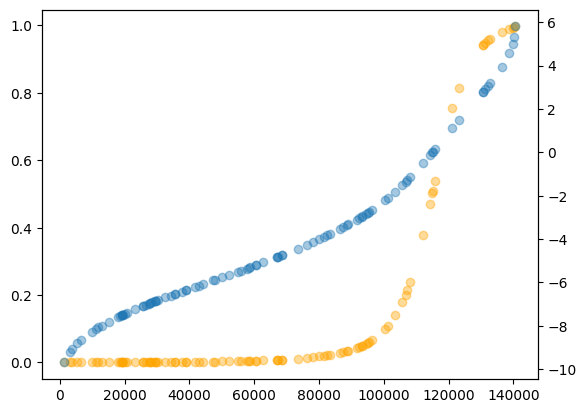

In [164]:
tmp = pd.DataFrame(oof_pred_probs)['XGBoost']
tmp = pd.DataFrame(
    {
        "Prob" : tmp.sort_values().reset_index(drop=True),
        "Logit" : logit(tmp.sort_values().clip(1e-15, 1-(1e-15)).reset_index(drop=True))
    }
).reset_index()
tmp_df = tmp.sample(100)
ax = plt.subplot()
ax.scatter(tmp_df['index'], tmp_df['Prob'], alpha = 0.4, color = 'orange')
ax1 = ax.twinx()
ax1.scatter(tmp_df['index'], tmp_df['Logit'], alpha = 0.4)

In [130]:
logit(pd.DataFrame(oof_pred_probs).clip(1e-15, 1-(1e-15)))

,LogisticRegression,LightGBM,XGBoost
0,-8.523921,-7.403172,-7.964151
1,0.802125,1.342068,1.331978
2,-0.019867,0.512024,0.232548
3,2.014475,1.957543,2.627670
4,-0.530810,-0.376125,-0.073459
...,...,...,...
140695,-0.255430,-0.225905,-0.011705
140696,-3.112482,-2.733058,-2.110905
140697,-2.702799,-2.535872,-2.417431
140698,-3.170852,-3.462594,-3.040993


In [119]:
X = logit(pd.DataFrame(oof_pred_probs).clip(1e-15, 1-1e-15))
X_test = logit(pd.DataFrame(test_pred_probs).clip(1e-15, 1-1e-15))

In [124]:
best_threshold = 0.495

lr_params = {
  "random_state": 42,
  "max_iter": 500,
  "C": 7.961535421147448,
  "tol": 0.0477686729246661,
  "fit_intercept": True,
  "class_weight": None,
  "solver": "newton-cholesky",
  "penalty": "l2"
}

In [125]:
lr_model = LogisticRegression(**lr_params)
lr_trainer = Trainer(lr_model, is_ensemble_model = True)
l2_oof_pred_probs['l2-ensemble-lr'], l2_test_pred_probs['l2-ensemble-lr'], scores['L2 Ensemble LR'], lr_coeffs = lr_trainer.fit_predict(X, y, X_test, None, None, best_threshold)

Training LogisticRegression

--- Fold 1 - Accuracy: 0.940689 (4 iterations)
--- Fold 2 - Accuracy: 0.939943 (4 iterations)
--- Fold 3 - Accuracy: 0.941542 (4 iterations)
--- Fold 4 - Accuracy: 0.940476 (4 iterations)
--- Fold 5 - Accuracy: 0.940441 (4 iterations)

------- Overall: 0.940618 | Average: 0.940618 +- 0.000523


In [126]:
save_submission('l2-ensemble-lr', l2_test_pred_probs['l2-ensemble-lr'], np.mean(scores['L2 Ensemble LR']), best_threshold)

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0


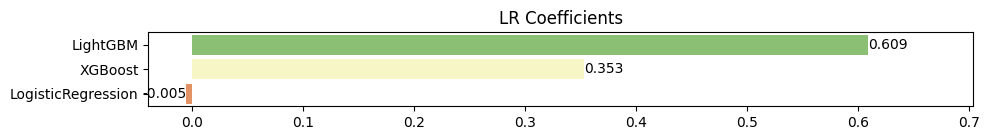

In [184]:
plot_weights(lr_coeffs, 'LR Coefficients')

# L2 Ridge

In [185]:
X = pd.DataFrame(oof_pred_probs)
X_test = pd.DataFrame(test_pred_probs)

In [186]:
best_threshold = 0.529

ridge_params = {
  "random_state": 42,
  "alpha": 0.6090067611181109,
  "tol": 0.009759013225878264,
  "positive": False,
  "fit_intercept": False
}

In [187]:
ridge_model = Ridge(**ridge_params)
ridge_trainer = Trainer(ridge_model, is_ensemble_model=True)
l2_oof_pred_probs['l2-ensemble-ridge'], l2_test_pred_probs['l2-ensemble-ridge'], scores['L2 Ensemble Ridge'], ridge_coeffs = ridge_trainer.fit_predict(X, y, X_test, None, None, best_threshold)

Training Ridge

--- Fold 1 - Accuracy: 0.941009
--- Fold 2 - Accuracy: 0.938913
--- Fold 3 - Accuracy: 0.941542
--- Fold 4 - Accuracy: 0.940618
--- Fold 5 - Accuracy: 0.940583

------- Overall: 0.940533 | Average: 0.940533 +- 0.000881


In [189]:
save_submission('l2-ensemble-ridge', l2_test_pred_probs['l2-ensemble-ridge'], np.mean(scores['L2 Ensemble Ridge']), best_threshold)

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0


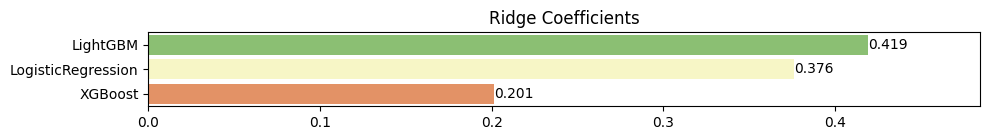

In [188]:
plot_weights(ridge_coeffs, 'Ridge Coefficients')

# L3 Weighted ensemble

In [202]:
def objective(trial):
    weights = np.array([trial.suggest_float(l2_model_name, 0, 1) for l2_model_name in l2_oof_pred_probs.keys()])
    weights /= np.sum(weights)
    
    preds = np.zeros(len(y))
    
    for model, weight in zip(l2_oof_pred_probs.keys(), weights):
        preds += l2_oof_pred_probs[model] * weight
        
    threshold = trial.suggest_float('threshold', 0.4, 0.6, step=0.001)
    
    return accuracy_score(y, (preds > threshold).astype(int))

sampler = optuna.samplers.TPESampler(seed = seed, n_startup_trials=50, multivariate = True)
study = optuna.create_study(direction = 'maximize', sampler = sampler)
study.optimize(objective, n_trials = 1000, n_jobs=-1)

[I 2024-11-17 08:48:21,179] A new study created in memory with name: no-name-5477c203-7228-4d13-b543-a4986cd40a2b
[I 2024-11-17 08:48:21,253] Trial 0 finished with value: 0.9393319118692253 and parameters: {'l2-ensemble-lr': 0.4092585490729962, 'l2-ensemble-ridge': 0.8750402344933759, 'threshold': 0.5900000000000001}. Best is trial 0 with value: 0.9393319118692253.
[I 2024-11-17 08:48:21,280] Trial 1 finished with value: 0.94045486851457 and parameters: {'l2-ensemble-lr': 0.5343595573362465, 'l2-ensemble-ridge': 0.3779834297166579, 'threshold': 0.523}. Best is trial 1 with value: 0.94045486851457.
[I 2024-11-17 08:48:21,297] Trial 2 finished with value: 0.9405828002842929 and parameters: {'l2-ensemble-lr': 0.02951114665194532, 'l2-ensemble-ridge': 0.7546062419310321, 'threshold': 0.514}. Best is trial 2 with value: 0.9405828002842929.
[I 2024-11-17 08:48:21,321] Trial 3 finished with value: 0.9385572139303483 and parameters: {'l2-ensemble-lr': 0.5260269909853841, 'l2-ensemble-ridge': 0

In [204]:
# ores['L3 Weighted Ensemble (LR + Ridge)'] = [study.best_value] * CFG.n_folds

In [210]:
scores['L3 Weighted Ensemble (LR + Ridge)'] = [study.best_value] * n_folds

In [211]:
scores

{'LogisticRegression': [0.9409026297085998,
  0.9381663113006397,
  0.9413290689410092,
  0.9404051172707889,
  0.939907604832978],
 'LightGBM': [0.939729921819474,
  0.9389836531627577,
  0.9408315565031983,
  0.9411158493248045,
  0.9398720682302771],
 'XGBoost': [0.9407960199004975,
  0.9380952380952381,
  0.9412224591329069,
  0.9389125799573561,
  0.9382018479033405],
 'L2 Ensemble LR': [0.9406894100923952,
  0.9399431414356787,
  0.9415422885572139,
  0.9404761904761905,
  0.9404406538734897],
 'L2 Ensemble Ridge': [0.9410092395167022,
  0.9389125799573561,
  0.9415422885572139,
  0.9406183368869936,
  0.9405828002842929],
 'L3 Weighted Ensemble (LR + Ridge)': [0.9407462686567164,
  0.9407462686567164,
  0.9407462686567164,
  0.9407462686567164,
  0.9407462686567164]}

In [213]:
study.best_params[]

{'l2-ensemble-lr': 0.39077896646699906,
 'l2-ensemble-ridge': 0.5179767799427661,
 'threshold': 0.495}

In [218]:
best_weights = np.array([study.best_params[l2_model] for l2_model in l2_oof_pred_probs.keys()])
best_weights /= np.sum(best_weights)
print(json.dumps({model:weight for model, weight in zip(l2_oof_pred_probs.keys(), best_weights)}, indent = 2))

best_threshold = study.best_params['threshold']
print(f'\nBest threshold: {best_threshold:.3f}')

{
  "l2-ensemble-lr": 0.4300154007398086,
  "l2-ensemble-ridge": 0.5699845992601914
}

Best threshold: 0.495


In [ ]:
plt.figure(figsize=(10, 6))
plt.pie(
    [v for k,v in study.best_params.items() if k != "threshold"], 
    labels=[k for k,v in study.best_params.items() if k != "threshold"], 
    autopct='%1.1f%%',
    colors=sns.color_palette('Set2', 2)
)
plt.title("L3 Ensemble Weights")
plt.tight_layout()
plt.show()